# Dim single point 

The single point non-dim network leads to the emergence of the issue where some of the non-dim flux magnitudes get very large. This leads to the model not training very well. Here we do some regularization to try and deal with this. 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-03 19:48:03.112780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-03 19:48:03.131188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-03 19:48:03.136821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup experiment

In [60]:
# We need one place to save all the experiment relevant info.  
experiment_config= {'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':1, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'mag_nabla_h_widened',
                                          'filter_scale', 
                                          'mag_nabla_u_widened',
                                          'uphp_rotated',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated',
                                          'vphp_rotated'],
                    
                    'coeff_channels'  : ['filter_scale','filter_scale','mag_nabla_h_widened', 'mag_nabla_u_widened'], 

                    'extra_channels'   : [],

                    'use_coeff_channels': True,

                    'all_time_range': slice(0, 800),
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'eval_time_range' : slice(-128, -64),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    #'num_inputs': 55, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt'
                    
            }
experiment_config['num_inputs'] = len(experiment_config['input_channels']) * experiment_config['window_size']**2

## SimulationData Module
#### Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [6]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'], 
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask_flag=True,
                             #e_ugrad = 1e-9,
                             #e_hgrad = 1e-5
                             )

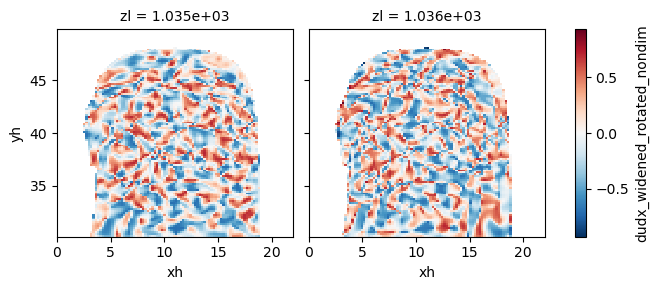

In [7]:
midpoint = int(experiment_config['window_size']/2)
DT.simulation_data['DG']['100'].dudx_widened_rotated_nondim.isel(Xn=midpoint,Yn=midpoint, Time=-1).plot(col='zl')

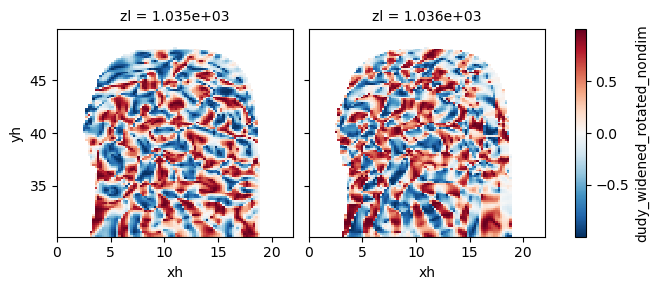

In [8]:
DT.simulation_data['DG']['100'].dudy_widened_rotated_nondim.isel(Xn=midpoint,Yn=midpoint, Time=-1).plot(col='zl')

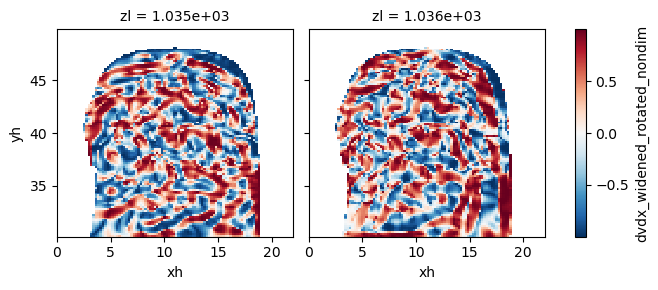

In [9]:
DT.simulation_data['DG']['100'].dvdx_widened_rotated_nondim.isel(Xn=midpoint,Yn=midpoint, Time=-1).plot(col='zl')

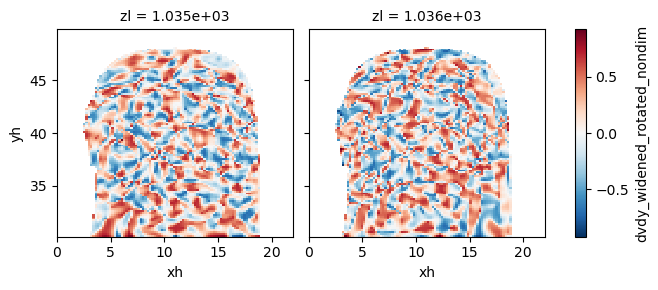

In [10]:
DT.simulation_data['DG']['100'].dvdy_widened_rotated_nondim.isel(Xn=midpoint,Yn=midpoint, Time=-1).plot(col='zl')

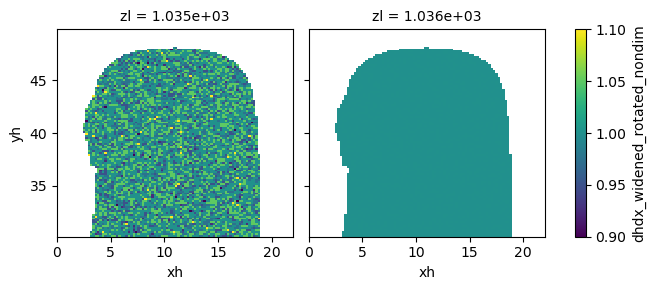

In [11]:
DT.simulation_data['DG']['100'].dhdx_widened_rotated_nondim.isel(Xn=midpoint,Yn=midpoint, Time=-1).plot(col='zl')

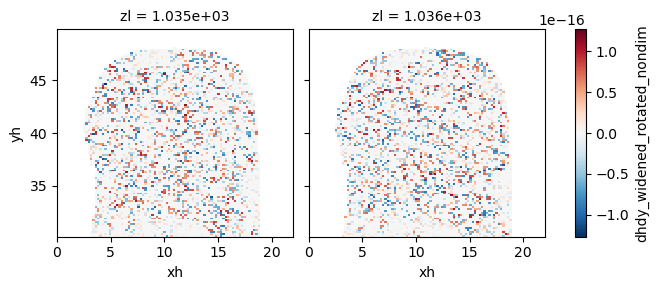

In [12]:
DT.simulation_data['DG']['100'].dhdy_widened_rotated_nondim.isel(Xn=midpoint,Yn=midpoint, Time=-1).plot(col='zl')

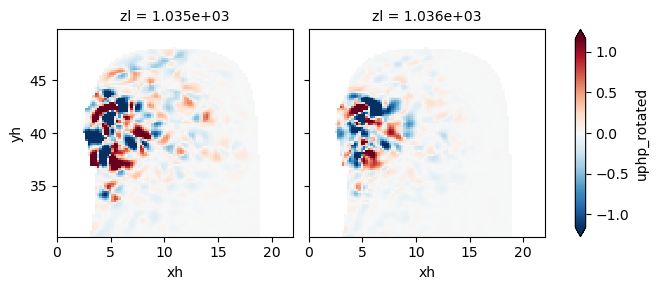

In [13]:
DT.simulation_data['DG']['100'].uphp_rotated.isel(Time=-1).plot(col='zl', robust=True)

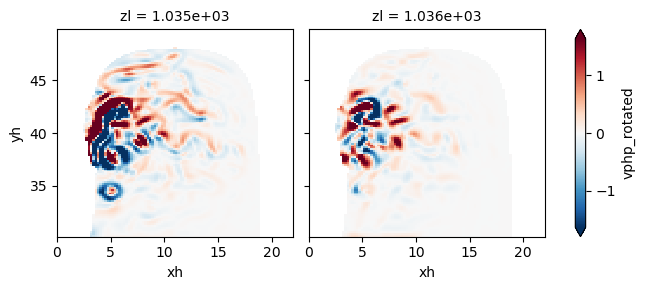

In [14]:
DT.simulation_data['DG']['100'].vphp_rotated.isel(Time=-1).plot(col='zl', robust=True)

## MLXarrayDataset 

Go from simulation data to batchesm but still as Xarray objects. 
In this step things like dropping extra points, masking of data etc happen. 

In [15]:
ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

Will load : 0.438272 gb into memory.
load took: 16.0562 seconds


In [16]:
ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 0.0438272 gb into memory.
load took: 2.6023 seconds


In [17]:
len(ML_DT_train.ml_batches), len(ML_DT_test.ml_batches) 

(37, 5)

In [18]:
ML_DT_train.ml_batches[0]

<xarray.Dataset> Size: 7MB
Dimensions:                      (Xn: 1, Yn: 1, points: 56192)
Coordinates:
  * points                       (points) object 450kB MultiIndex
  * Time                         (points) object 450kB 0011-12-05 00:00:00 .....
  * xh                           (points) float64 450kB 15.95 16.77 ... 15.02
  * yh                           (points) float64 450kB 33.18 38.14 ... 30.14
  * zl                           (points) float64 450kB 1.036e+03 ... 1.035e+03
Dimensions without coordinates: Xn, Yn
Data variables:
    dudx_widened_rotated_nondim  (Xn, Yn, points) float64 450kB -0.5136 ... 0...
    dvdx_widened_rotated_nondim  (Xn, Yn, points) float64 450kB 0.458 ... 0.819
    dudy_widened_rotated_nondim  (Xn, Yn, points) float64 450kB -0.5099 ... 0...
    dvdy_widened_rotated_nondim  (Xn, Yn, points) float64 450kB 0.5162 ... 0....
    dhdx_widened_rotated_nondim  (Xn, Yn, points) float64 450kB 1.0 1.0 ... 1.0
    dhdy_widened_rotated_nondim  (Xn, Yn, points) float64 450kB 0.0 ... 8.14e-18
    mag_nabla_h_widened          (points) float64 450kB 4.725e-05 ... 0.0001041
    filter_scale                 (points) float64 450kB 1.006e+05 ... 5.115e+04
    mag_nabla_u_widened          (points) float64 450kB 4.105e-08 ... 9.193e-08
    uphp_rotated                 (points) float64 450kB -0.0007951 ... -0.000...
    vphp_rotated                 (points) float64 450kB 0.000781 ... 0.007171
Attributes:
    simulation_name:  DG
    filter_scale:     50
    source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
    description:      Dataset for DG experiment at 50 km resolution

## MLJAXDataset 

### Convert these xbatcher batches to processed ones for training

This needs to take care of extra dims, like Xn,Yn.

In [19]:
batch_xr = ML_DT_train.ml_batches[0]

In [20]:
import matplotlib.pyplot as plt
import math

def plot_distributions(xr_dataset, variables):
    """
    Plots histograms for each variable in the provided dataset.

    Parameters:
    xr_dataset: xarray.Dataset
        The dataset containing the variables to be plotted.
    variables: list
        A list of variable names to be plotted.
    """
    num_vars = len(variables)
    num_cols = 2  # Adjust columns as needed
    num_rows = math.ceil(num_vars / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 3 * num_rows))

    axes = axes.flatten()  # Flatten in case of multiple rows

    for i, var in enumerate(variables):
        xr_dataset[var].plot.hist(ax=axes[i])
        axes[i].set_title(var)

    # Hide unused subplots if num_vars is not a perfect multiple of num_cols
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [21]:
experiment_config['all_ml_variables']

['dudx_widened_rotated_nondim',
 'dvdx_widened_rotated_nondim',
 'dudy_widened_rotated_nondim',
 'dvdy_widened_rotated_nondim',
 'dhdx_widened_rotated_nondim',
 'dhdy_widened_rotated_nondim',
 'mag_nabla_h_widened',
 'filter_scale',
 'mag_nabla_u_widened',
 'uphp_rotated',
 'vphp_rotated']

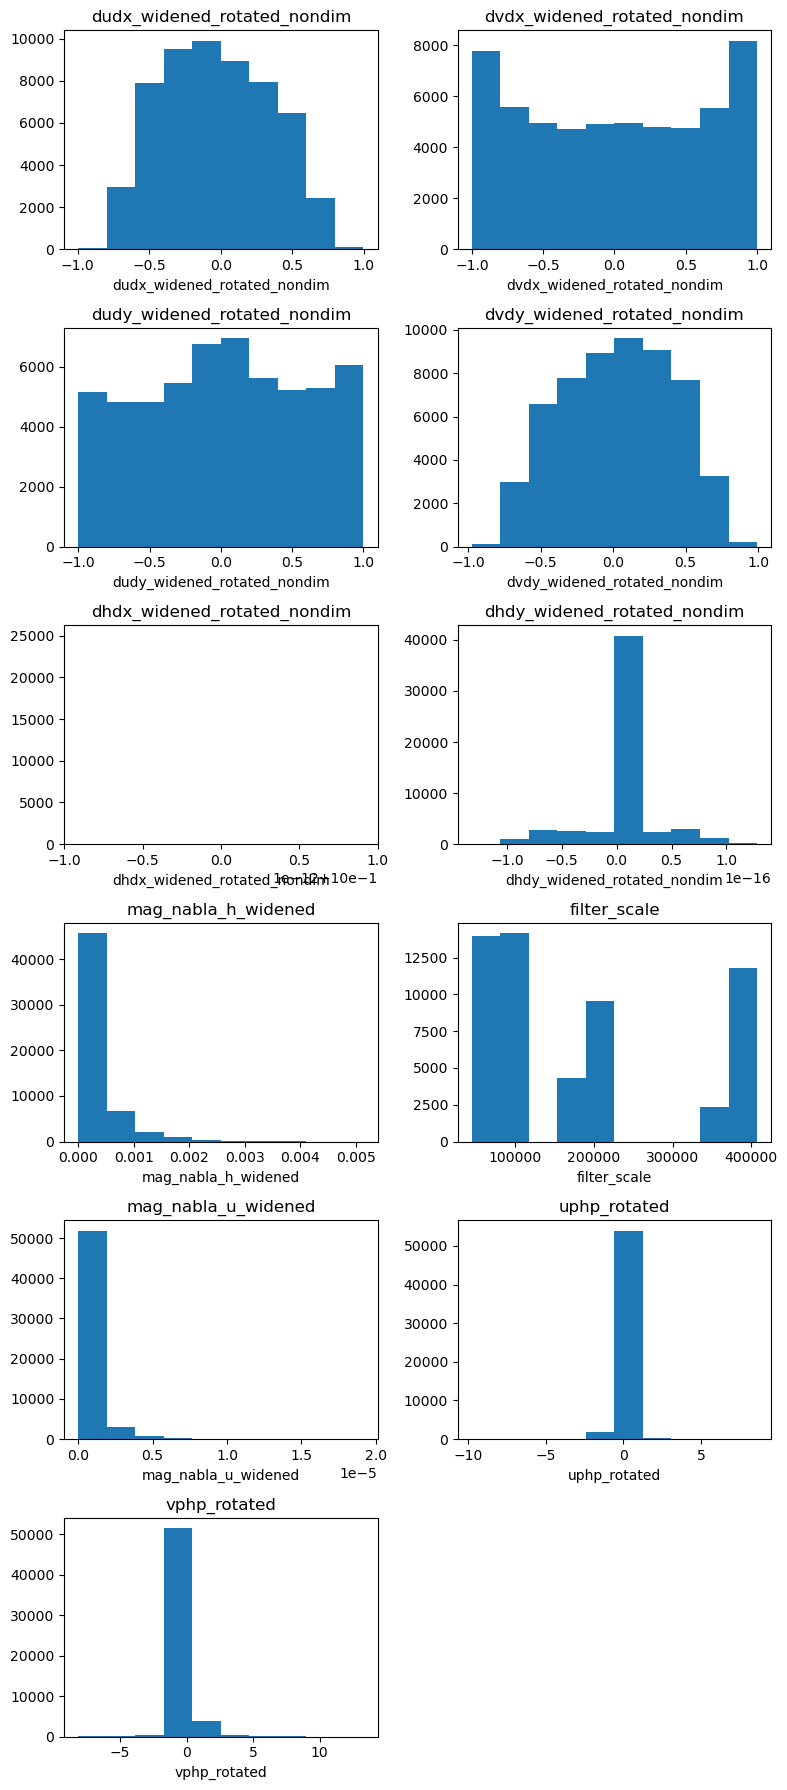

In [22]:
plot_distributions(batch_xr, experiment_config['all_ml_variables'])

In [23]:
batch_xr.std()

<xarray.Dataset> Size: 88B
Dimensions:                      ()
Data variables:
    dudx_widened_rotated_nondim  float64 8B 0.371
    dvdx_widened_rotated_nondim  float64 8B 0.6311
    dudy_widened_rotated_nondim  float64 8B 0.5647
    dvdy_widened_rotated_nondim  float64 8B 0.3777
    dhdx_widened_rotated_nondim  float64 8B 1.551e-16
    dhdy_widened_rotated_nondim  float64 8B 3.05e-17
    mag_nabla_h_widened          float64 8B 0.0004178
    filter_scale                 float64 8B 1.301e+05
    mag_nabla_u_widened          float64 8B 1.056e-06
    uphp_rotated                 float64 8B 0.3463
    vphp_rotated                 float64 8B 0.6162

In [24]:
# Define the variables and assign normalizations 

normalize_data_dic = {
    'dudx': ([], 1e-6),  # scalar value
    'dvdx': ([], 1e-6),
    'dudy': ([], 1e-6),
    'dvdy': ([], 1e-6),
    'dhdx': ([], 1e-3),
    'dhdy': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'uphp': ([], 4.),
    'vphp': ([], 4.),
    'dudx_widened': ([], 1e-6),  # scalar value
    'dvdx_widened': ([], 1e-6),
    'dudy_widened': ([], 1e-6),
    'dvdy_widened': ([], 1e-6),
    'dhdx_widened': ([], 1e-3),
    'dhdy_widened': ([], 1e-3),
    'dhdx_widened_rotated': ([], 1e-3),
    'dhdy_widened_rotated': ([], 1e-3),
    
    'dudx_widened_rotated_nondim': ([], 1.),  # scalar value
    'dvdx_widened_rotated_nondim': ([], 1.),
    'dudy_widened_rotated_nondim': ([], 1.),
    'dvdy_widened_rotated_nondim': ([], 1.),
    'dhdx_widened_rotated_nondim': ([], 1.),
    'dhdy_widened_rotated_nondim': ([], 1.),
    'mag_nabla_h_widened': ([], 1e-3),
    'mag_nabla_u_widened': ([], 1e-6),
    'uphp_rotated': ([], 1e-1 / experiment_config['window_size']**2),
    'vphp_rotated': ([], 1e-1 / experiment_config['window_size']**2),
    'uphp_rotated_nondim': ([], 1 / experiment_config['window_size']**2),
    'vphp_rotated_nondim': ([], 1 / experiment_config['window_size']**2),
}

# Eventually would be good to save this normalization factors dictionary with the one
# that keeps all the experiment config information. 


ds_norm = xr.Dataset(normalize_data_dic)

In [25]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      use_coeff_channels=experiment_config['use_coeff_channels'],
                                      ds_norm=ds_norm)

In [26]:
test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      use_coeff_channels=experiment_config['use_coeff_channels'],
                                      ds_norm=ds_norm)

In [27]:
ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [28]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Input (Xp) batch shape:", batch_out['Xp'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (56192, 6)
Input (Xp) batch shape: (56192, 1)
Output (y) batch shape: (56192, 2)


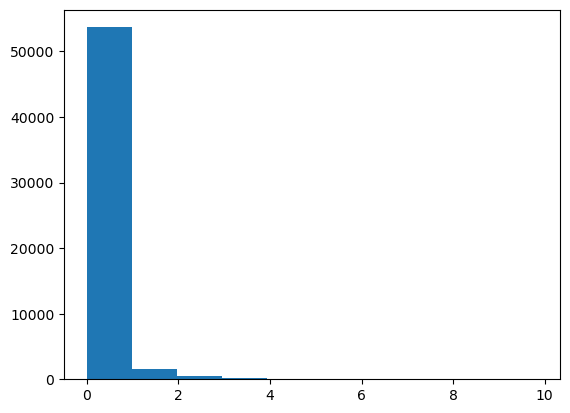

In [29]:
plt.hist(batch_out['Xp'][:,0]);

## AnnRegressionSystem (and associated NN setup modules ArtificialNeuralNetwork and PointwiseANN).


In [30]:
num_in = batch_out['X'].shape[-1]
experiment_config['num_inputs'] = num_in
experiment_config['num_inputs']

6

In [31]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [32]:
ANN_model.count_parameters()

1658


In [33]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model, loss_type='mae')

In [34]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=101, print_freq=2)

At epoch 1. Train loss :  1.3205502999795449 , Test loss: 1.154663872718811 , Test R2: 0.29383009672164917
At epoch 3. Train loss :  1.029909984485523 , Test loss: 1.1361593723297119 , Test R2: 0.2909579396247864
At epoch 5. Train loss :  1.0285783555056598 , Test loss: 1.1345622777938842 , Test R2: 0.2960724592208862
At epoch 7. Train loss :  1.0278546487962879 , Test loss: 1.1339745759963988 , Test R2: 0.2985940337181091
At epoch 9. Train loss :  1.0270776362032503 , Test loss: 1.1329784870147706 , Test R2: 0.2996333122253418
At epoch 11. Train loss :  1.0257581762365393 , Test loss: 1.1311918497085571 , Test R2: 0.3008822202682495
At epoch 13. Train loss :  1.0242011031588993 , Test loss: 1.1295366764068604 , Test R2: 0.30528299808502196
At epoch 15. Train loss :  1.0227078747104954 , Test loss: 1.1281845808029174 , Test R2: 0.30972267389297486
At epoch 17. Train loss :  1.0215241619058557 , Test loss: 1.1270518541336059 , Test R2: 0.3135270357131958
At epoch 19. Train loss :  1.020

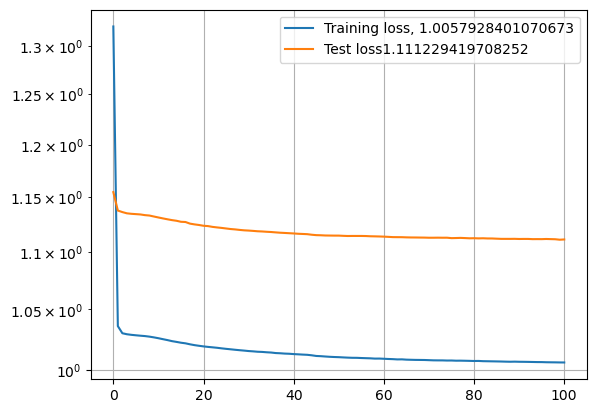

In [35]:
## Loss plot
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.grid()
plt.yscale('log')
plt.legend()

In [36]:
experiment_config['exp_ckpt_save_dir']

'/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt'

In [37]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

In [38]:
regress_sys.state.params['params']['layers_0']['kernel']

Array([[-5.02630949e-01, -1.89098728e+00,  8.25997829e-01,
         1.16003901e-01, -1.16941679e+00,  8.89437258e-01,
        -3.19625318e-01, -1.43603802e+00, -3.32880989e-02,
         1.58893511e-01, -2.44629931e+00, -5.39658368e-02,
        -1.55563998e+00,  6.16680980e-01,  9.99394283e-02,
         2.53085971e+00,  4.03820306e-01,  2.13883474e-01,
        -1.10380745e+00, -1.48682284e+00, -6.01310611e-01,
        -4.92070794e-01, -5.81057131e-01,  1.10407937e+00,
        -6.56591833e-01, -6.06159971e-04, -2.97067904e+00,
         8.63265574e-01,  4.22538400e-01, -1.65996647e+00,
        -2.06201386e+00, -2.55322385e+00,  2.66441554e-01,
         9.77972209e-01, -1.80669391e+00,  6.83983639e-02],
       [ 5.56219459e-01, -5.43304160e-02, -6.17457449e-01,
         9.71817449e-02,  1.02784269e-01, -4.72340196e-01,
        -4.53679025e-01, -2.23265842e-01, -9.66857970e-01,
        -5.38463771e-01,  3.69098425e-01, -9.76881310e-02,
         6.48312092e-01, -4.49727356e-01,  1.20219931e-

Testing around saving check points 

Check if data can be reloaded in, we do this in a new object.

In [39]:
new_regress_sys =  ML_classes.AnnRegressionSystem(ANN_model)

In [40]:
new_regress_sys.read_checkpoint(experiment_config['exp_ckpt_save_dir'])

In [41]:
new_regress_sys.network.count_parameters()

1658


In [42]:
new_regress_sys.state.params['params']['layers_0']['kernel']

Array([[-5.02630949e-01, -1.89098728e+00,  8.25997829e-01,
         1.16003901e-01, -1.16941679e+00,  8.89437258e-01,
        -3.19625318e-01, -1.43603802e+00, -3.32880989e-02,
         1.58893511e-01, -2.44629931e+00, -5.39658368e-02,
        -1.55563998e+00,  6.16680980e-01,  9.99394283e-02,
         2.53085971e+00,  4.03820306e-01,  2.13883474e-01,
        -1.10380745e+00, -1.48682284e+00, -6.01310611e-01,
        -4.92070794e-01, -5.81057131e-01,  1.10407937e+00,
        -6.56591833e-01, -6.06159971e-04, -2.97067904e+00,
         8.63265574e-01,  4.22538400e-01, -1.65996647e+00,
        -2.06201386e+00, -2.55322385e+00,  2.66441554e-01,
         9.77972209e-01, -1.80669391e+00,  6.83983639e-02],
       [ 5.56219459e-01, -5.43304160e-02, -6.17457449e-01,
         9.71817449e-02,  1.02784269e-01, -4.72340196e-01,
        -4.53679025e-01, -2.23265842e-01, -9.66857970e-01,
        -5.38463771e-01,  3.69098425e-01, -9.76881310e-02,
         6.48312092e-01, -4.49727356e-01,  1.20219931e-

Making predictions using some batch. 

In [43]:
y_true = batch_out['y']

In [44]:
y_pred = new_regress_sys.pred(batch_out['X'], batch_out['Xp'])

In [45]:
y_pred

Array([[-8.8326465e-03,  7.0781279e-03],
       [-1.7481206e-02,  9.7940406e-03],
       [ 1.9505827e-02,  5.8700042e-03],
       ...,
       [ 5.6442595e-03, -1.3547131e-01],
       [ 6.4078164e-01,  1.9126142e+00],
       [-1.4996488e-03,  1.8467493e-02]], dtype=float32)

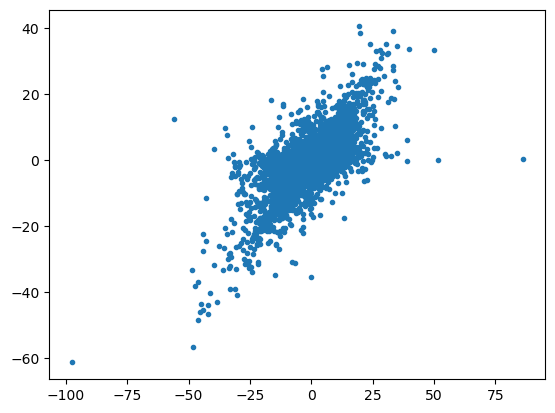

In [46]:
plt.plot(y_true[:,0], y_pred[:,0],'.')


The above prediction method works, but we would like a little more functionality. 
We want to be able to make predictions on the original grids and structure of the data (e.g. at different scales), so we can track performance in real space (rather than sample space). To do all this, we will be developing an evaluation module. 

## Evaluation Module

In [47]:
DT

In [61]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 extra_channels=experiment_config['extra_channels'],
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=experiment_config['eval_time_range'], 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'],
                                 use_coeff_channels=experiment_config['use_coeff_channels'])

In [62]:
experiment_config['exp_ckpt_save_dir']

'/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt'

In [63]:
test_eval.read_ann_regression_model()

In [64]:
test_eval.regress_sys.network.params['params']['layers_0']['kernel']

Array([[-0.78813124, -0.6668143 ,  0.8600535 ,  0.11406235, -0.00690051,
        -0.06378416, -0.41255763, -0.46724308,  0.22381784,  0.15889351,
        -0.29766995, -0.06553236, -0.3397788 ,  0.5966437 ,  0.6509855 ,
         0.6973157 ,  0.4695304 ,  0.51518035,  0.7542129 , -0.12105707,
        -0.6013106 , -0.47334665, -0.21877426,  0.19783033,  0.2751735 ,
        -0.18878095, -0.11172464,  0.3628587 ,  0.07606886, -0.8274317 ,
        -0.17336157, -0.3564192 ,  0.36093226,  0.7819023 ,  0.02878594,
         0.13493206],
       [ 0.38354152,  0.1773394 , -0.4019    ,  0.11004332, -0.01364905,
        -0.29071036, -0.5442635 , -0.2080747 , -0.60164225, -0.5384638 ,
         0.5199117 , -0.1230018 ,  0.6091561 , -0.07609301,  0.11986447,
         0.35291088, -0.7404294 , -0.55978173, -0.1408327 , -0.13084403,
         0.34380108, -0.03524955,  0.17457005,  0.25499246, -0.69517696,
         0.36162943, -0.07363991,  0.83942974, -0.05091805, -0.58542275,
        -0.4735389 , -0.21960

In [65]:
test_eval.read_eval_data()

In [66]:
test_eval.eval_datatree.ml_dataset['DG']['100']

DataTree('100', parent="DG")
    Dimensions:                      (Time: 64, zl: 2, yh: 108, xh: 100, Xn: 1,
                                      Yn: 1)
    Coordinates:
      * Time                         (Time) object 512B 0019-06-06 00:00:00 ... 0...
      * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
      * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
      * zl                           (zl) float64 16B 1.035e+03 1.036e+03
    Dimensions without coordinates: Xn, Yn
    Data variables:
        dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 11MB dask.array<chunksize=(12, 2, 108, 100, 1, 1), meta=np.ndarray>
        dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 11MB dask.array<chunksize=(12, 2, 108, 100, 1, 1), meta=np.ndarray>
        dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 11MB dask.array<chunksize=(12, 2, 108, 100, 1, 1), meta=np.ndarray>
        dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 11MB dask.array<chunksize=(12, 2, 108, 100, 1, 1), meta=np.ndarray>
        dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 11MB dask.array<chunksize=(12, 2, 108, 100, 1, 1), meta=np.ndarray>
        dhdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 11MB dask.array<chunksize=(12, 2, 108, 100, 1, 1), meta=np.ndarray>
        uphp_rotated                 (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 108, 100), meta=np.ndarray>
        vphp_rotated                 (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 108, 100), meta=np.ndarray>
        filter_scale                 (yh, xh, Time) float64 6MB dask.array<chunksize=(108, 100, 12), meta=np.ndarray>
        mag_nabla_h_widened          (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 108, 100), meta=np.ndarray>
        mag_nabla_u_widened          (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 108, 100), meta=np.ndarray>
        h_mask                       (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 108, 100), meta=np.ndarray>
    Attributes:
        simulation_name:  DG
        filter_scale:     100
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
        description:      Dataset for DG experiment at 100 km resolution

In [67]:
test_eval.predict()

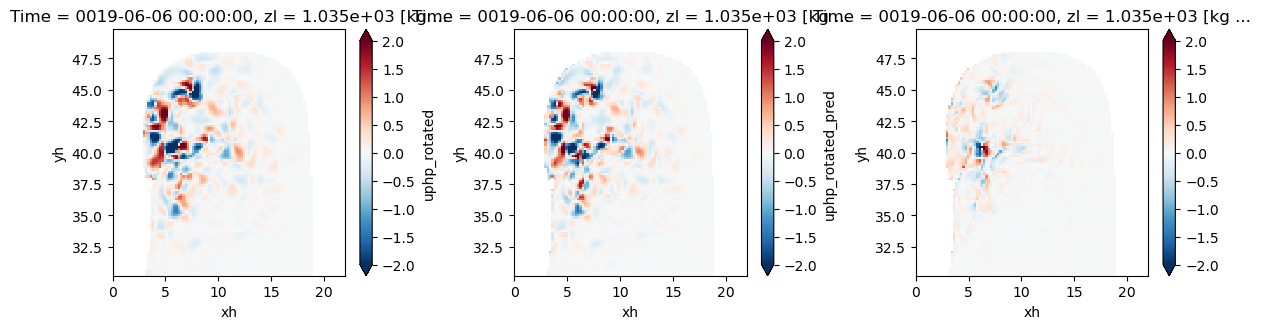

In [68]:
plt.figure(figsize=(12, 3.4))
exp_name = experiment_config['simulation_names'][0]
zl = 0
vmin = -2

plt.subplot(131)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(132)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl).plot(vmin=vmin)

plt.tight_layout()

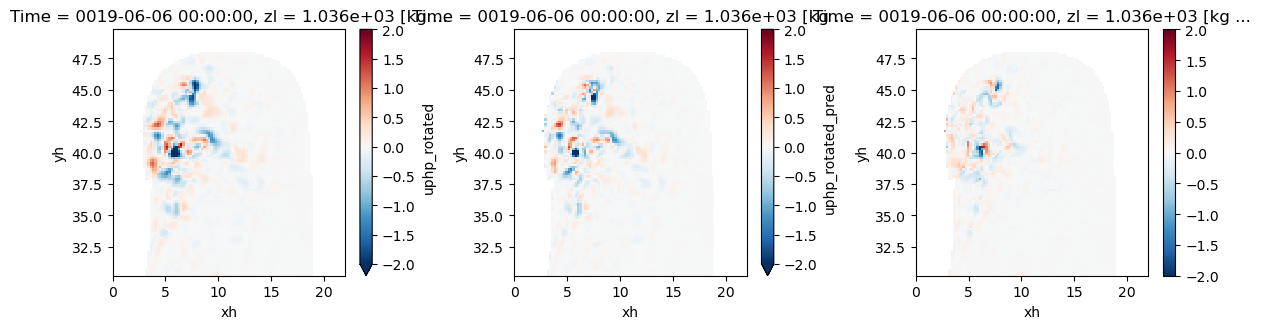

In [69]:
plt.figure(figsize=(12, 3.4))
exp_name = experiment_config['simulation_names'][0]
zl = 1
vmin = -2

plt.subplot(131)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(132)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl).plot(vmin=vmin)

plt.tight_layout()

In [70]:
test_eval.calc_time_hor_space_metrics(var='uphp_rotated', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval.calc_time_hor_space_metrics(var='vphp_rotated', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])


test_eval.calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
test_eval.calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])

In [71]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_rotated_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_rotated_R2_layer_wise.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.93348024 0.8927376 ]
DG 50km, R2 for vphp is (layer:[0,1])[0.9691144  0.90067953]
DG 100km, R2 for uphp is (layer:[0,1])[0.84553062 0.7018819 ]
DG 100km, R2 for vphp is (layer:[0,1])[0.90234676 0.80327867]
DG 200km, R2 for uphp is (layer:[0,1])[0.5759374  0.32063239]
DG 200km, R2 for vphp is (layer:[0,1])[0.68548607 0.49914991]
DG 400km, R2 for uphp is (layer:[0,1])[0.22784251 0.03426858]
DG 400km, R2 for vphp is (layer:[0,1])[0.50528223 0.05862683]


In [1]:
for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 5.5))

    test_eval.eval_datatree.ml_dataset[exp][scale].uphp_rotated_R2_time.plot(col='zl', vmax=1)
    plt.title(scale)

NameError: name 'experiment_config' is not defined